<a href="https://colab.research.google.com/github/vinzentp/Mission-Calypso/blob/master/TS_Prediction_Madrid_Weater_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras as keras
from tensorflow.keras.callbacks import EarlyStopping

def show_plot_of_predicted_vs_true(X, y_pred, y_true):
  
  X_flat = [feature for timestep in X for feature in timestep]

  plt.figure(figsize = (20,8))
  plt.plot(X_flat, marker = '.')
  plt.plot(range(len(X_flat), len(X_flat)+len(y_pred)), y_pred, marker = 'x')
  plt.plot(range(len(X_flat), len(X_flat)+len(y_true)), y_true, marker = '.')

df = pd.read_csv('madrid.csv')
df['time'] = pd.to_datetime(df['time'])

df = df.sort_values('time')

# Shape definitions
n_steps = 50
y_pred_steps = 10
timesteps_per_batch = n_steps + y_pred_steps

# Calculating the number of batches
n_batches = len(df) // timesteps_per_batch

# Triming the data to a multiple of the batch size
df = df[:n_batches * timesteps_per_batch]


# Droping everything but the temperature
#df = df[['temperature', 'wind_speed', 'wind_direction', 'humidity', 'barometric_pressure','solar_radiation','precipitation']]
df = df[['temperature']]

# Reshaping the data into a 3D array
data = df.values.reshape((n_batches, timesteps_per_batch, -1))

# Converting the data to a numpy array
data = np.array(data)

In [112]:
# Defining split sizes
train_size = int(n_batches * 0.7)
validation_size = int(n_batches * 0.15)
test_size = n_batches - train_size - validation_size

# Splitting in train, validation and test set
X_train, y_train = data[:train_size, :n_steps], data[:train_size, -y_pred_steps:, 0]
X_valid, y_valid = data[train_size:train_size+validation_size, :n_steps], data[train_size:train_size+validation_size, -y_pred_steps:, 0]
X_test, y_test = data[train_size+validation_size:, :n_steps], data[train_size+validation_size:, -y_pred_steps:, 0]

In [ ]:
# Creating a model
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=([None, 1])),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
for i in range(10):
  show_plot_of_predicted_vs_true(X_test[i], y_pred[i], y_test[i])

In [115]:
Y = np.empty((len(data), n_steps, y_pred_steps)) 
for step_ahead in range(1, y_pred_steps + 1):
  for i in range(len(data)):
    for j in range(n_steps):
      Y[i,j,step_ahead-1] = data[i, j+step_ahead, 0]

y_train = Y[:train_size]
y_valid = Y[train_size:train_size + validation_size]
y_test = Y[train_size+validation_size:]

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(y_pred_steps))
])


def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:, -1])

# Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=200)


model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs= 2000, validation_data=(X_valid, y_valid), callbacks=[early_stop])



Epoch 1/2000
10/10 [==============================] - 2s 55ms/step - loss: 214.7733 - last_time_step_mse: 216.4839 - val_loss: 280.3947 - val_last_time_step_mse: 279.4896
Epoch 2/2000
10/10 [==============================] - 0s 18ms/step - loss: 202.4646 - last_time_step_mse: 203.8617 - val_loss: 268.6786 - val_last_time_step_mse: 267.5766
Epoch 3/2000
10/10 [==============================] - 0s 18ms/step - loss: 194.8082 - last_time_step_mse: 196.1978 - val_loss: 260.6000 - val_last_time_step_mse: 259.6104
Epoch 4/2000
10/10 [==============================] - 0s 19ms/step - loss: 189.0267 - last_time_step_mse: 190.4671 - val_loss: 253.5124 - val_last_time_step_mse: 252.6284
Epoch 5/2000
10/10 [==============================] - 0s 22ms/step - loss: 183.6891 - last_time_step_mse: 185.2259 - val_loss: 247.0029 - val_last_time_step_mse: 246.2000
Epoch 6/2000
10/10 [==============================] - 0s 22ms/step - loss: 178.8389 - last_time_step_mse: 180.4232 - val_loss: 240.6448 - val_las

In [117]:
tf.keras.models.save_model(
    model,
    "model_rnn",
    save_format="tf",
    signatures=None,
    options=None
)

3/3 [==============================] - 0s 6ms/step
2.3714886667792427


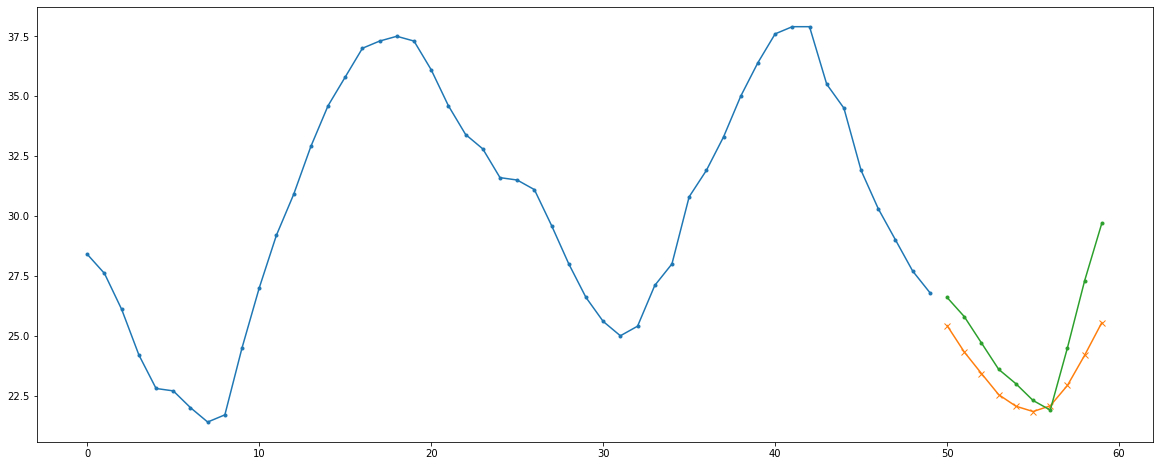

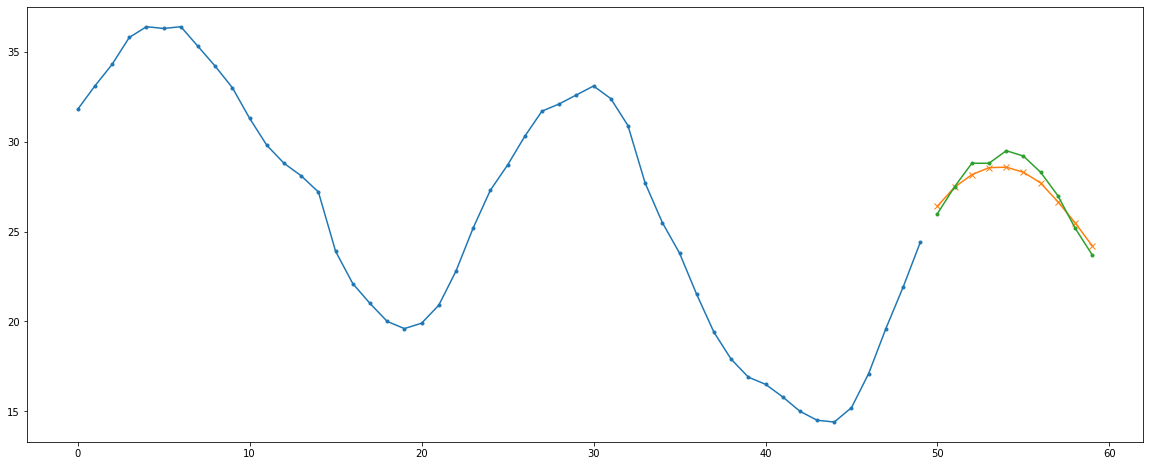

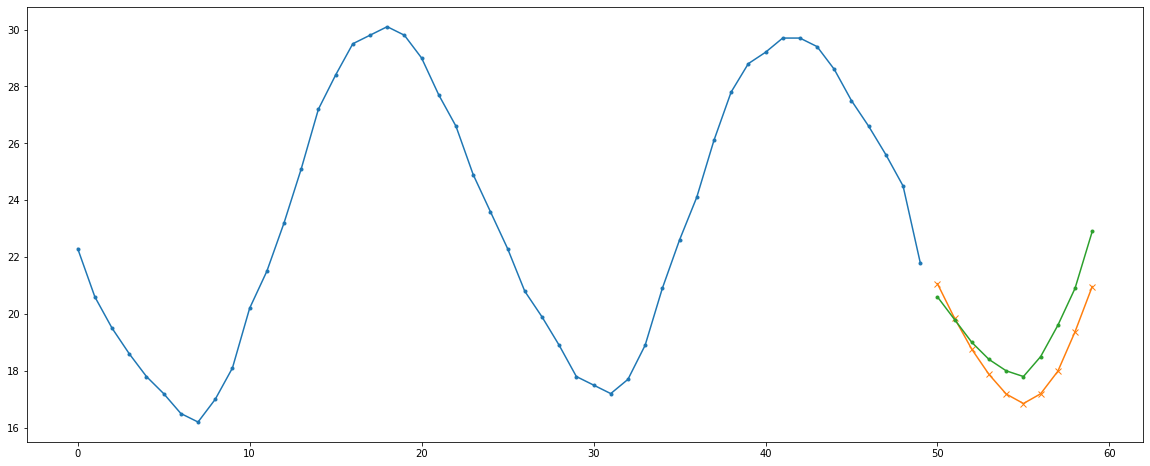

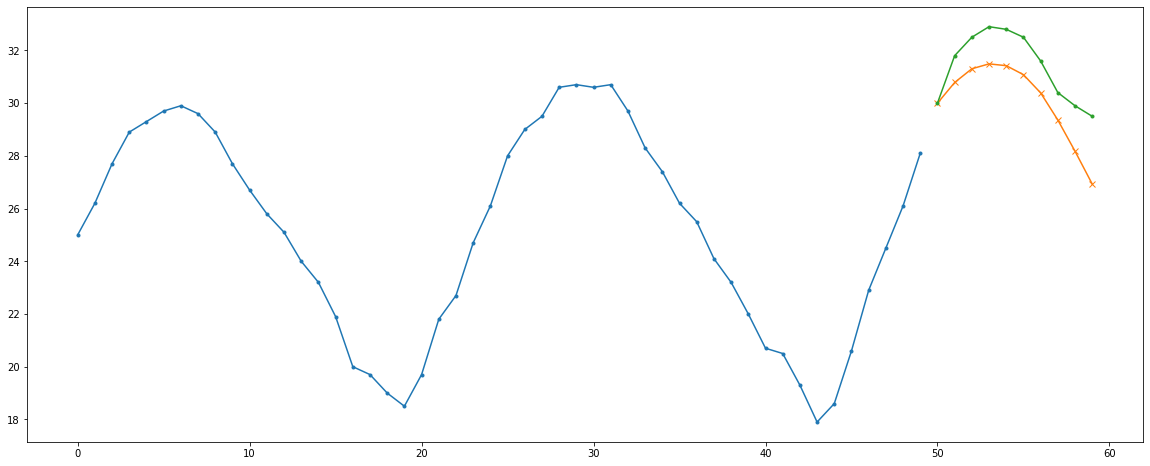

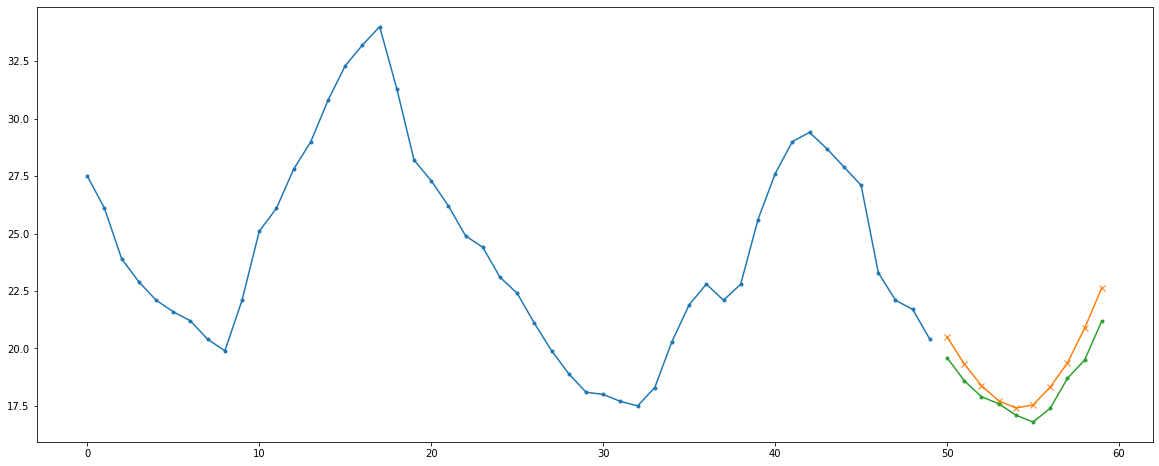

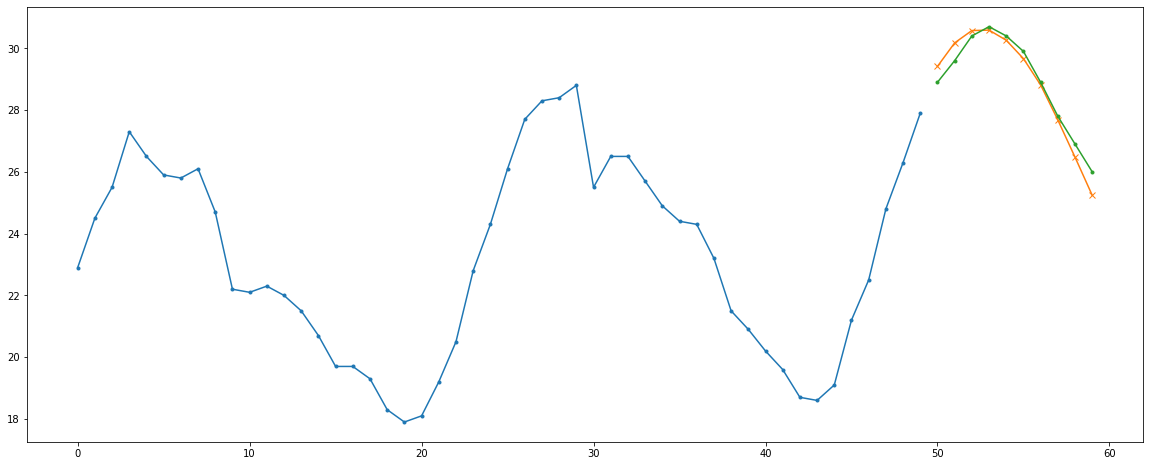

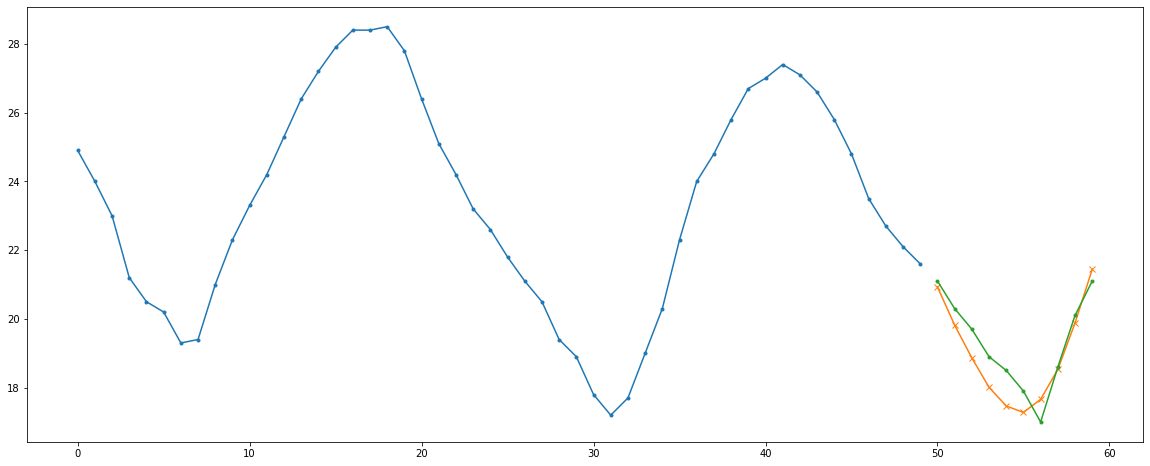

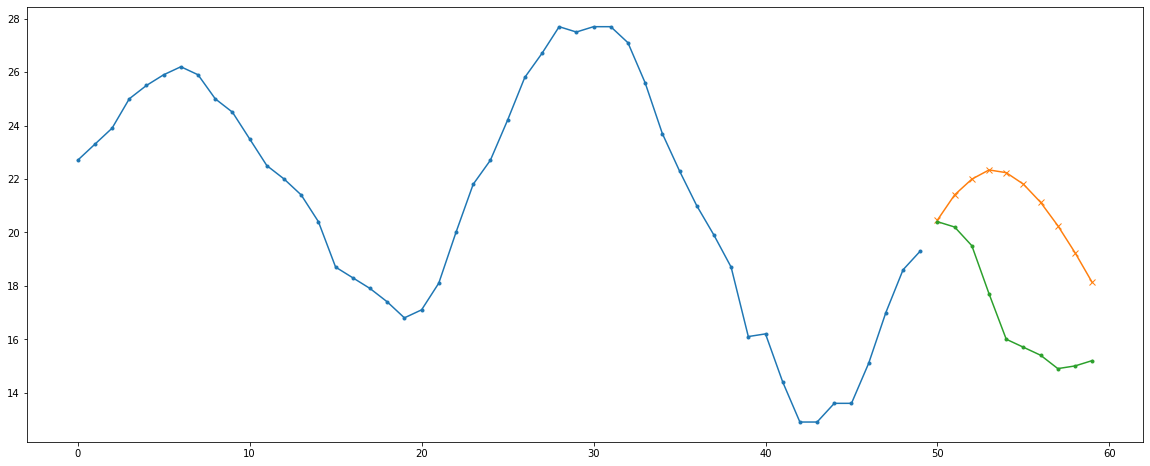

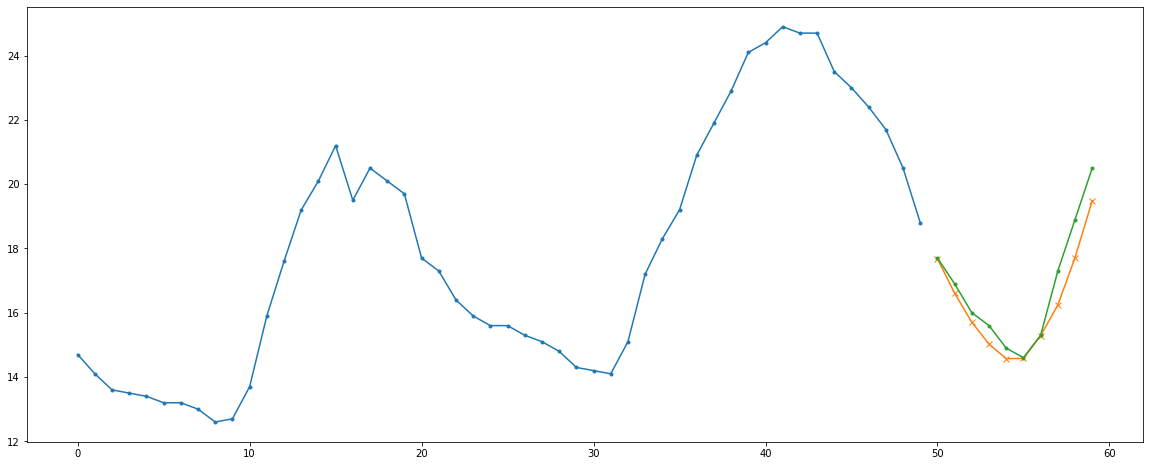

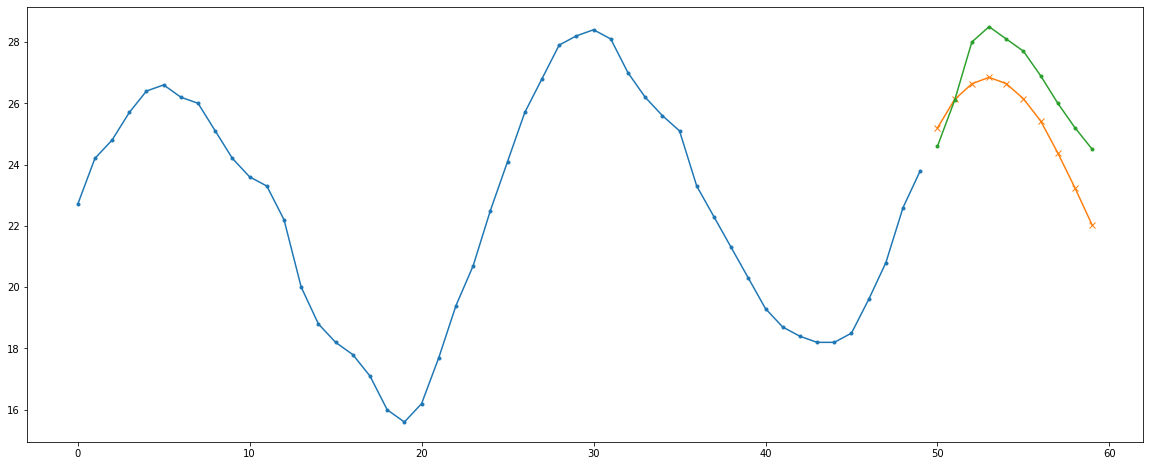

In [116]:
y_pred = model.predict(X_test)
print(np.array(last_time_step_mse(y_pred, y_test)).mean())
for i in range(10):
  show_plot_of_predicted_vs_true(X_test[i], y_pred[i][-1], y_test[i][-1])